#### GATE-GNN Preprocessing

In [1]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=495091 sha256=6201d8a3ce8b63911f7980558f87e35e5b206ee2c719d269279c74f1155af94d
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch-scatter
Looking in links: https://data.pyg.org/whl/torch-.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=1035675 sha256=4400197e86c60aed6bd5664362ac13fa68210f2b84612238de774596c5d20dd3
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38c
Successfully built torch-sparse
  Cloning h

In [2]:
import time
import tensorflow as tf
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)
print(tf.__version__)

2.15.0


In [3]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
## determine the dataset: cora, citeseer, and pubmed
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print(data)

Processing...


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Done!


In [4]:
dataset = Planetoid(root=data_dir, name='Cora')
data = dataset[0]
print(f'Number of nodes: {data.num_nodes}') # Number of nodes: based on the dataset you choose
print(f'Number of edges: {data.num_edges}') # Number of edges: based on the dataset

Processing...


Number of nodes: 2708
Number of edges: 10556


Done!


In [5]:
print(f'Has isolated nodes: {data.has_isolated_nodes()}')  # False
print(f'Has self-loops: {data.has_self_loops()}')  # False
print(f'Is undirected: {data.is_undirected()}')  # True

Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [6]:
edge_index = data.edge_index.numpy()
print(edge_index.shape)
edge_example = edge_index[:, np.where(edge_index[0]==30)[0]]
edge_example

(2, 10556)


array([[  30,   30,   30,   30,   30,   30],
       [ 697,  738, 1358, 1416, 2162, 2343]])

Average node degree: 3.90


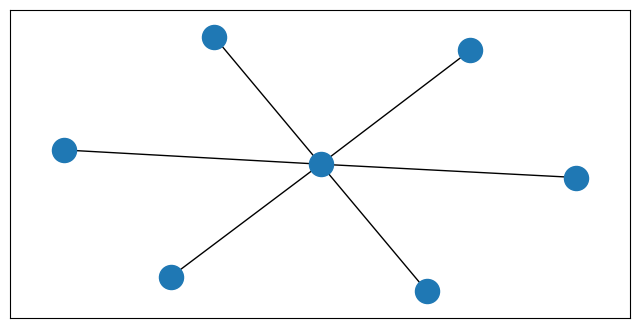

In [7]:
node_example = np.unique(edge_example.flatten())
plt.figure(figsize=(8, 4))
G = nx.Graph()
G.add_nodes_from(node_example)
G.add_edges_from(list(zip(edge_example[0], edge_example[1])))
nx.draw_networkx(G, with_labels=False)
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}') # Average node degree: 3.90

,count,mean,std,min,25%,50%,75%,max
0,2708.0,3.9,5.23,1.0,2.0,3.0,5.0,168.0


2708
10556


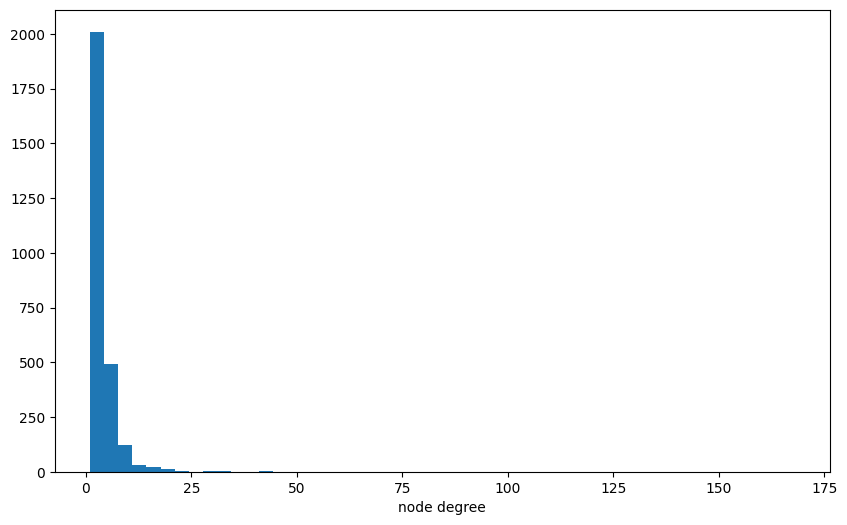

In [8]:
G = to_networkx(data, to_undirected=True)
degrees = [val for (node, val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
print(len(degrees))
print(sum(degrees))
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50)
plt.xlabel("node degree")
plt.show()

threshold 0.011821204285186553


/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


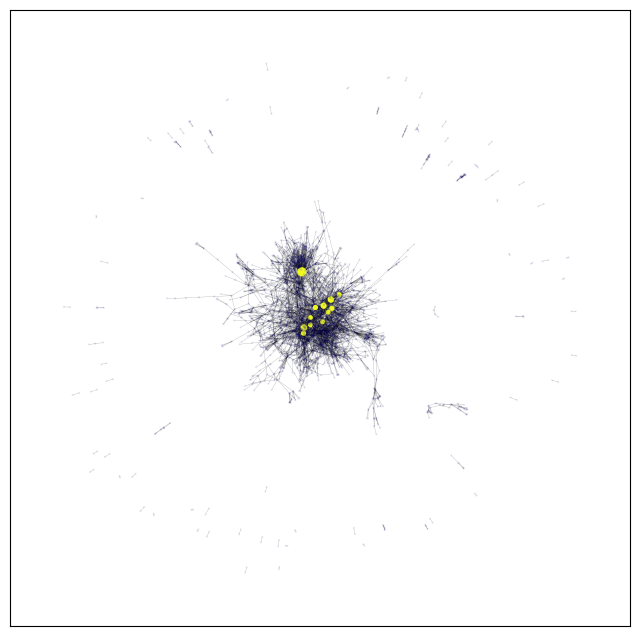

In [9]:
G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, seed=42)
cent = nx.degree_centrality(G)
node_size = list(map(lambda x: x * 500, cent.values()))
cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(8, 8))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin)
edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
plt.show()

In [10]:
print(f'Number of features: {data.num_node_features}') # Number of edge features: 0
print(len(data.x[0])) #display some of the features, and you can
#see that they are composed of 0s and 1s
data.x[0][:20]
print(f'Number of edge features: {data.num_edge_features}') # Number of edge features: 0
print(f'Number of classes: {dataset.num_classes}') # Number of classes: 7

Number of features: 1433
1433
Number of edge features: 0
Number of classes: 7


In [11]:
#the details for our dataset
label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"}
data.y[:10]

tensor([3, 4, 4, 0, 3, 2, 0, 3, 3, 2])

{3: 818, 4: 426, 0: 351, 2: 418, 1: 217, 5: 298, 6: 180}


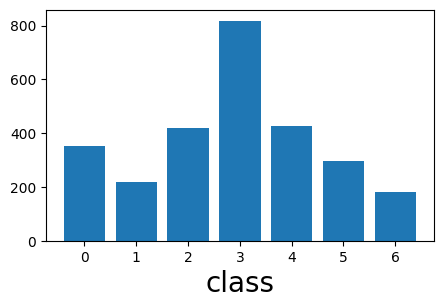

In [12]:
counter = collections.Counter(data.y.numpy())
counter = dict(counter)
print(counter)
count = [x[1] for x in sorted(counter.items())]
plt.figure(figsize=(5, 3))
plt.bar(range(7), count) # for Cora is 7 and Citeseer is 6, Pubmed=3
plt.xlabel("class", size=20)
plt.show()

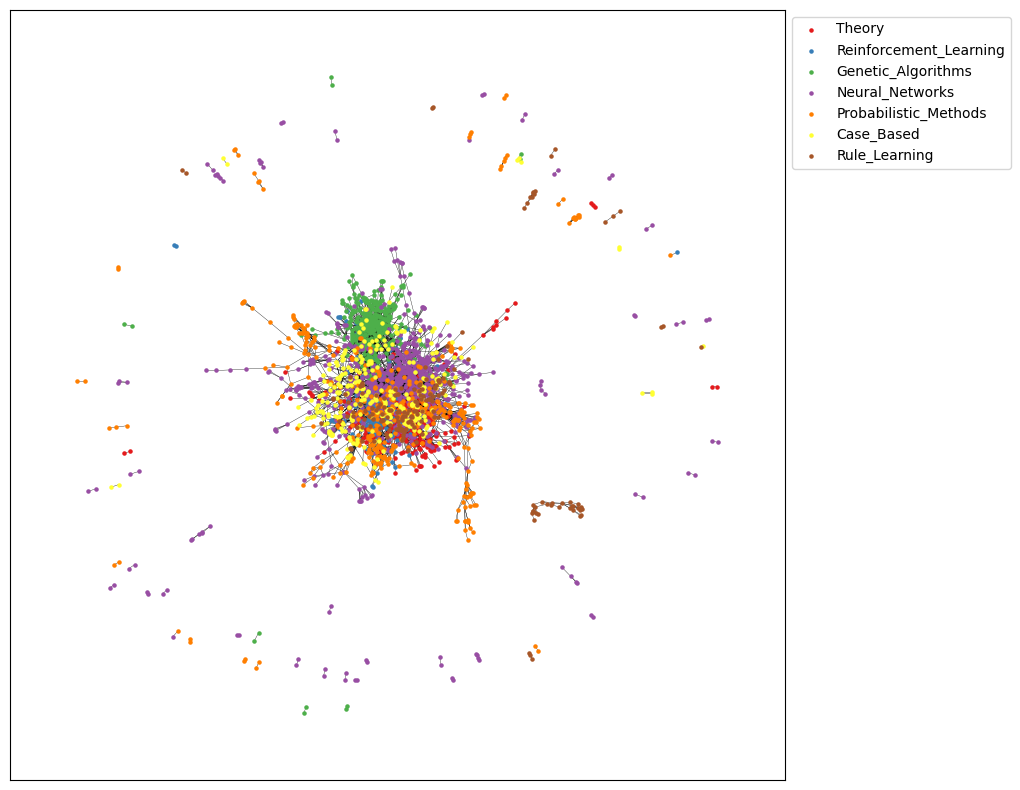

In [13]:
#draw a network diagram to see if the classes are distributed coherently
G = to_networkx(data, to_undirected=True)
node_color = []
nodelist = [[], [], [], [], [], [], []]
colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']
labels = data.y
for n, i in enumerate(labels):
    node_color.append(colorlist[i])
    nodelist[i].append(n)
pos = nx.spring_layout(G, seed = 42)
plt.figure(figsize = (10, 10))
labellist = list(label_dict.values())
for num, i in enumerate(zip(nodelist, labellist)):
    n, l = i[0], i[1]
    nx.draw_networkx_nodes(G, pos, nodelist=n, node_size = 5, node_color = colorlist[num], label=l)
nx.draw_networkx_edges(G, pos, width = 0.25)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

label: 0
1527 edges
{0: 1068, 3: 161, 5: 75, 4: 88, 1: 32, 6: 80, 2: 23}
label: 1
1029 edges
{0: 32, 1: 818, 2: 62, 6: 2, 5: 28, 3: 67, 4: 20}
label: 2
1826 edges
{3: 53, 2: 1654, 5: 30, 0: 23, 1: 62, 4: 2, 6: 2}
label: 3
2838 edges
{3: 2350, 4: 137, 0: 161, 5: 54, 1: 67, 2: 53, 6: 16}
label: 4
1592 edges
{4: 1320, 3: 137, 0: 88, 1: 20, 6: 6, 5: 19, 2: 2}
label: 5
1086 edges
{5: 834, 3: 54, 6: 46, 0: 75, 1: 28, 2: 30, 4: 19}
label: 6
658 edges
{6: 506, 0: 80, 3: 16, 5: 46, 4: 6, 1: 2, 2: 2}


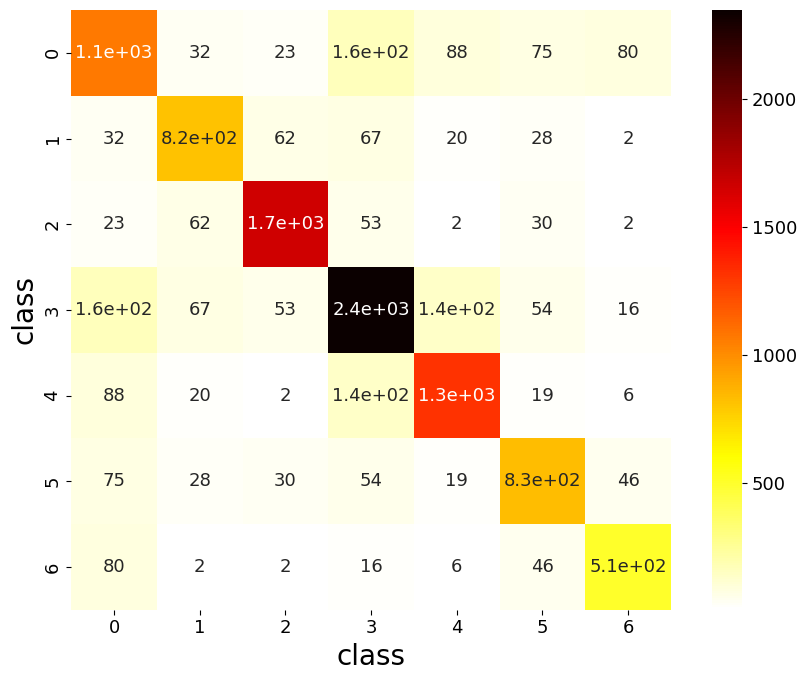

In [14]:
#For the seven classes we looked at earlier, we will see how many nodes of the same
#class are connected by edges and vice versa. This property is called homophily.
labels = data.y.numpy()
connected_labels_set = list(map(lambda x: labels[x], data.edge_index.numpy()))
connected_labels_set = np.array(connected_labels_set)
def add_missing_keys(counter, classes):
    for x in classes:
        if x not in counter.keys():
            counter[x] = 0
    return counter
label_connection_counts = []
for i in range(7):
    print(f"label: {i}")
    connected_labels = connected_labels_set[:, np.where(connected_labels_set[0] == i)[0]]
    print(connected_labels.shape[1], "edges")
    counter = collections.Counter(connected_labels[1])
    counter = dict(counter)
    print(counter)
    counter = add_missing_keys(counter, range(7)) # CORA =7, Coteseer=6, PubMed=3
    items = sorted(counter.items())
    items = [x[1] for x in items]
    label_connection_counts.append(items)
label_connection_counts = np.array(label_connection_counts)
plt.figure(figsize=(9, 7))
plt.rcParams["font.size"] = 13
hm = sns.heatmap(label_connection_counts, annot=True, cmap='hot_r', cbar=True, square=True)
plt.xlabel("class",size=20)
plt.ylabel("class",size=20)
plt.tight_layout()
plt.show()

In [16]:
# we calculate the percentage of edges connected within the same class.
label_connection_counts.diagonal().sum() / label_connection_counts.sum()

0.8099658961727927

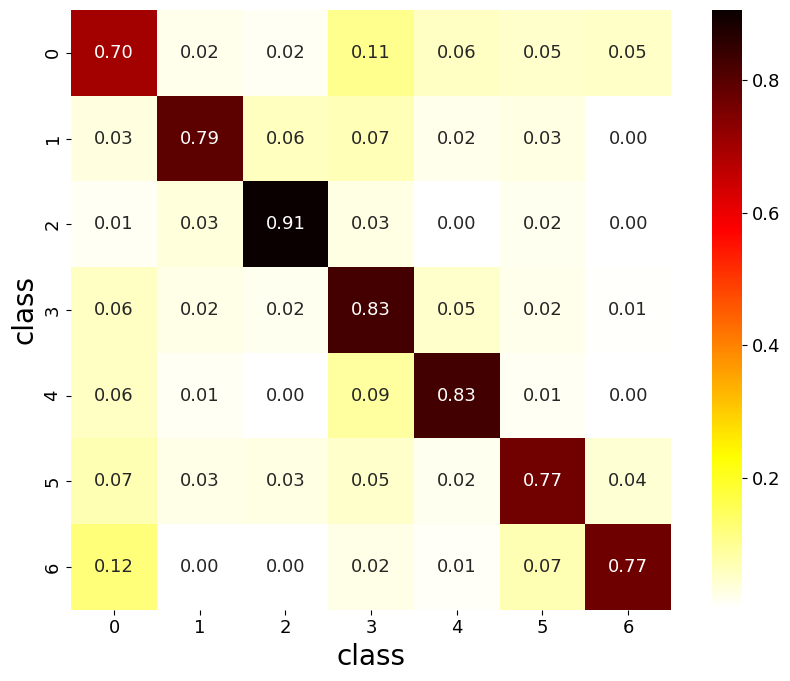

In [17]:
#Determine the edges that are connected within the same class.
def scaling(array):
    return array / sum(array)
label_connection_counts_scaled = np.apply_along_axis(scaling, 1, label_connection_counts)
plt.figure(figsize=(9, 7))
plt.rcParams["font.size"] = 13
hm = sns.heatmap(
    label_connection_counts_scaled,
    annot=True,
    cmap='hot_r',
    fmt="1.2f",
    cbar=True,
    square=True)
plt.xlabel("class",size=20)
plt.ylabel("class",size=20)
plt.tight_layout()
plt.show()

Training {3: 20, 4: 20, 0: 20, 2: 20, 1: 20, 5: 20, 6: 20}
Validation {4: 81, 3: 158, 0: 61, 6: 29, 1: 36, 2: 78, 5: 57}
Test {3: 319, 2: 144, 0: 130, 1: 91, 5: 103, 4: 149, 6: 64}


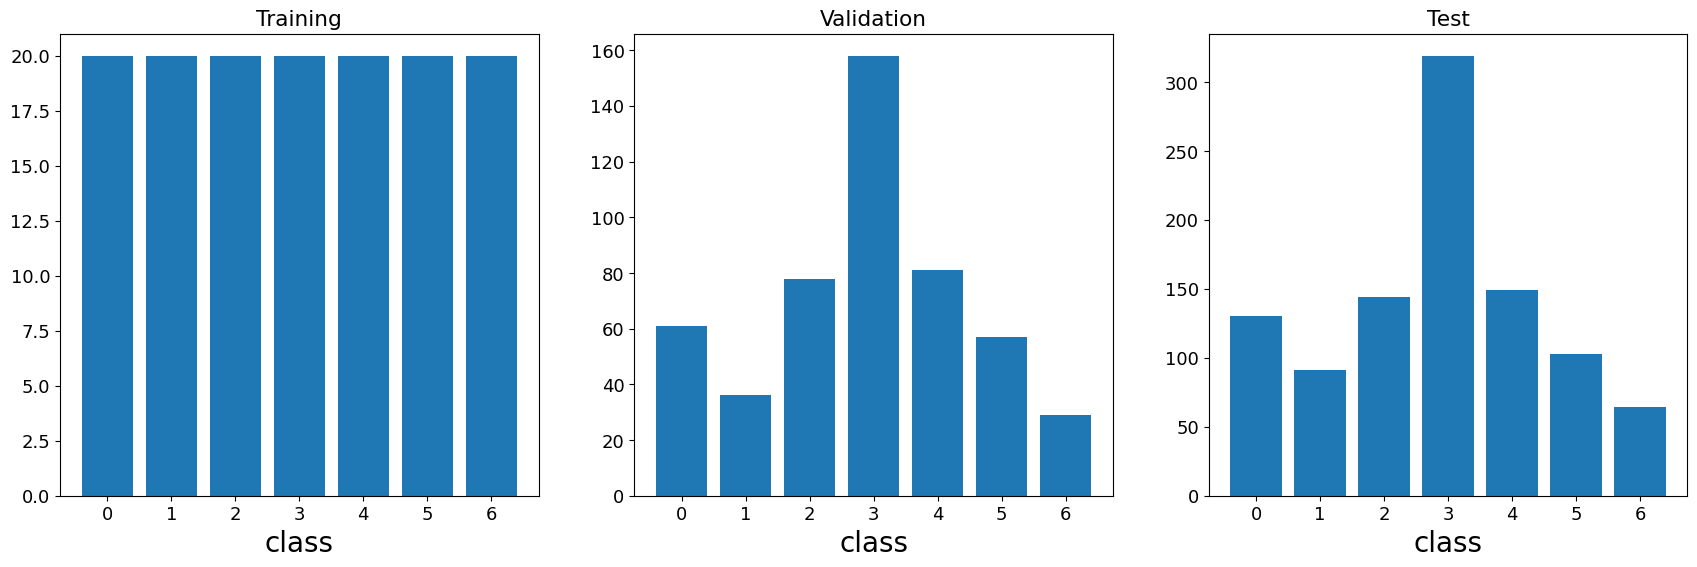

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [19]:
## Cora Dataset
split_type_array = np.zeros(data.num_nodes)
split_type_array[np.where(data.train_mask == True)[0]] = 1
split_type_array[np.where(data.val_mask == True)[0]] = 2
split_type_array[np.where(data.test_mask == True)[0]] = 3
split_type_array
titles = ["Training", "Validation", "Test"]
fig, axes = plt.subplots(ncols=3, figsize=(21, 6))
for i in range(3):
    counter = collections.Counter(data.y.numpy()[np.where(split_type_array == i + 1)[0]])
    counter = dict(counter)
    print(titles[i], counter)
    count = [x[1] for x in sorted(counter.items())]
    plt.figure(figsize=(10, 6))
    axes[i].bar(range(7), count)
    axes[i].set_xlabel("class", size=20)
    axes[i].set_title(titles[i])
plt.show()

In [20]:
import torch.nn as nn
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(123)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [21]:
model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


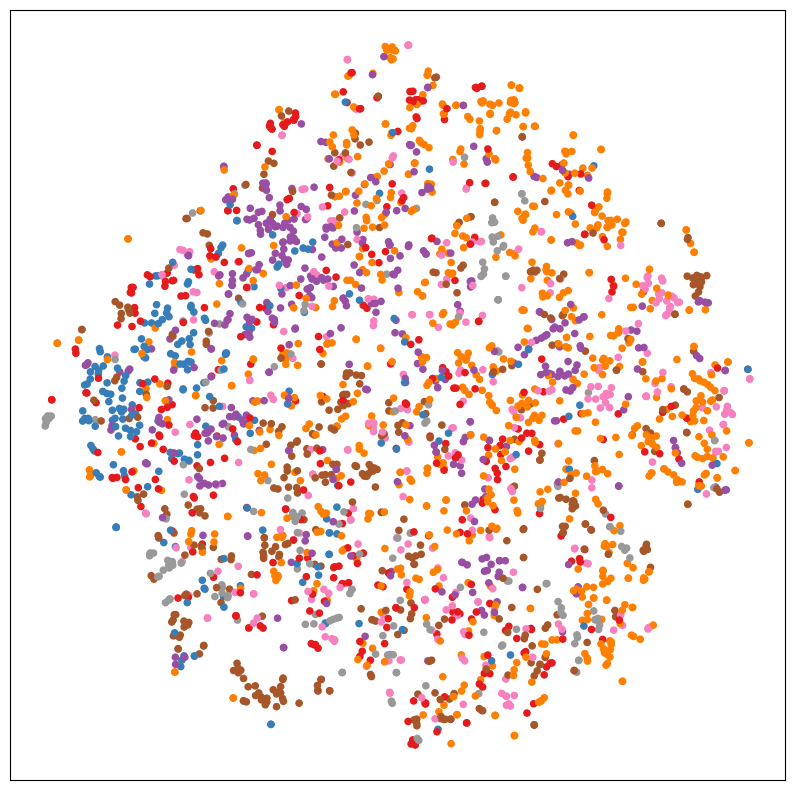

In [22]:
#visualising the untrained GCN Network
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=20, c=color, cmap="Set1")
    plt.show()

model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

## Visualise the Confusion Matrix of GCN

Processing...
Done!


Epoch: 200, Loss: 0.0275, Train: 1.0000, Val: 0.7600, Test: 0.7970
[[100   4   2   7   6   2   9]
 [  5  82   1   2   0   0   1]
 [  3  10 124   6   1   0   0]
 [ 28   8   6 236  31   5   5]
 [ 10   1   1   8 122   6   1]
 [  8   4   4   1   0  78   8]
 [  6   0   0   1   0   2  55]]
     0   1    2    3    4   5   6
0  100   4    2    7    6   2   9
1    5  82    1    2    0   0   1
2    3  10  124    6    1   0   0
3   28   8    6  236   31   5   5
4   10   1    1    8  122   6   1
5    8   4    4    1    0  78   8
6    6   0    0    1    0   2  55


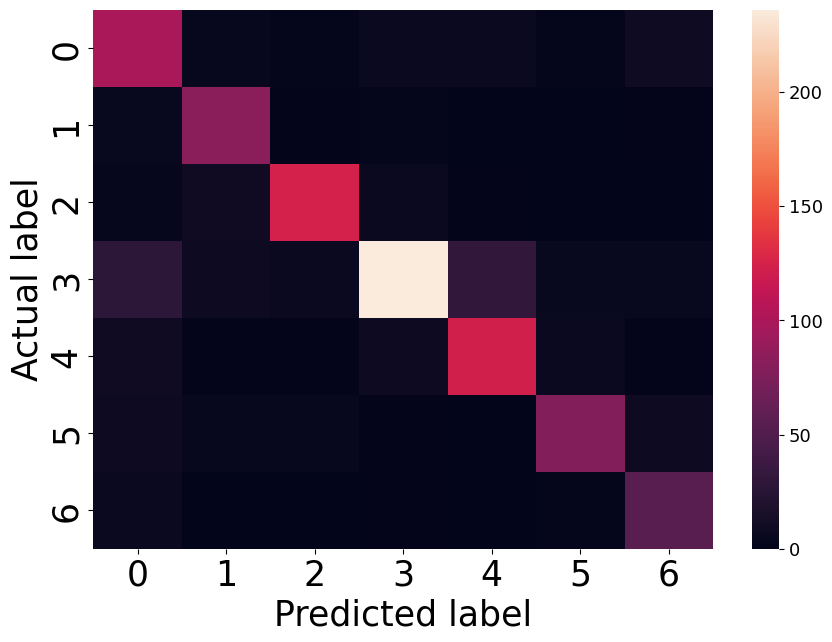

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric as tg
from sklearn import metrics
import sklearn as sk
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd

#Load the PubMed dataset : Cora, Citeseer, PubMed, NELL
dataset = tg.datasets.Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

#Split the dataset into training, validation and test sets
train_mask = data.train_mask
val_mask = data.val_mask
test_mask = data.test_mask
y_train = data.y[train_mask]
y_val = data.y[val_mask]
y_test = data.y[test_mask]

#Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x


#model = GCN(dataset.num_node_features, 16, dataset.num_classes)
#model = model_func(input_dim=features[2][1], logging=True)
model = GCN(hidden_channels=16)

#Define the optimizer and the loss function
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

#Train the model
def train():
  model.train()
  optimizer.zero_grad()
  out = model(data.x, data.edge_index)
  loss = criterion(out[train_mask], y_train)
  loss.backward()
  optimizer.step()
  return loss.item()

#Evaluate the model
@torch.no_grad()
def test():
  model.eval()
  out = model(data.x, data.edge_index)
  pred = out.argmax(dim=1)
  acc_train = pred[train_mask].eq(y_train).sum().item() / y_train.size(0)
  acc_val = pred[val_mask].eq(y_val).sum().item() / y_val.size(0)
  acc_test = pred[test_mask].eq(y_test).sum().item() / y_test.size(0)
  return acc_train, acc_val, acc_test

#Run the training and testing loop
for epoch in range(1, 201):
  loss = train()
  acc_train, acc_val, acc_test = test()
print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {acc_train:.4f}, Val: {acc_val:.4f}, Test: {acc_test:.4f}')

#Predict the labels of the test set
model.eval()
out = model(data.x, data.edge_index)
pred = out.argmax(dim=1)
y_pred = pred[test_mask].numpy()
y_true = y_test.numpy()

x_labels = ['Class 1', 'Class 2', 'Class 3']
y_labels = ['Class 1', 'Class 2', 'Class 3']

x_fontsize = 25
y_fontsize = 25
legend_fontsize = 25
cmap_fontsize = 25
#Compute the confusion matrix
cm = sk.metrics.confusion_matrix(y_true, y_pred)
print(cm)

#Display the confusion matrix as a table
df_cm = pd.DataFrame(cm, index = [i for i in range(dataset.num_classes)],
columns = [i for i in range(dataset.num_classes)])
print(df_cm)

#Display the confusion matrix as a heatmap
plt.figure (figsize = (10, 7))

plt.xticks (np.arange (len (x_labels)), x_labels, fontsize = x_fontsize)
plt.yticks (np.arange (len (y_labels)), y_labels, fontsize = y_fontsize)

sn.heatmap(df_cm, annot=False, cmap='rocket')
plt.xlabel ('Predicted label', fontsize = x_fontsize)
plt.ylabel ('Actual label', fontsize = y_fontsize)
plt.title ('', fontsize = legend_fontsize)
plt.show ()

## Check the Embedding Learned by GCN using PCA

Processing...
Done!


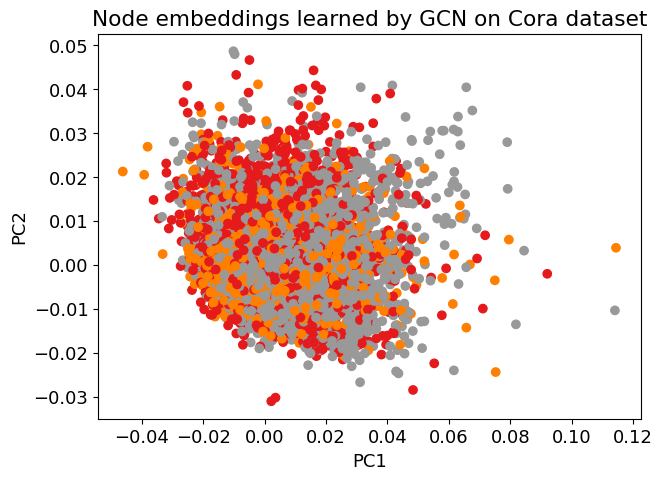

In [24]:
import torch
import torch.nn as nn
import torch_geometric as tg
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
from torch.nn import ReLU, Dropout
import torch.nn.functional as F

#Load the dataset
dataset = tg.datasets.Planetoid(root='/tmp/PubMed', name='PubMed')
data = dataset[0]

#Define the GCN model
class GCN(nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels):
    super(GCN, self).__init__()
    torch.manual_seed(42)
    self.conv1 = GCNConv(in_channels, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, out_channels)

  def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x


#Create an instance of the GCN model
in_channels = dataset.num_node_features
out_channels = dataset.num_classes

model = GCN(hidden_channels=16, in_channels=in_channels, out_channels=out_channels)

#Train the model

model.train()
for epoch in range(10):
  pass

#Get the node embeddings from the model
model.eval()
out = model(data.x, data.edge_index)
embeddings = out.detach().numpy()

#Apply PCA to reduce the dimensionality of the embeddings
pca = sk.decomposition.PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

#Plot the node embeddings using scatter plot
plt.figure(figsize=(7,5))
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=data.y, cmap="Set1")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Node embeddings learned by GCN on Cora dataset")
plt.show()
